# Neural Networks with a Deep Learning Framework - PyTorch

1. In Practical9a.ipynb, we will first look at the same problem from the Practical 8 - classification of sklearn "moons".
2. Then, in Practical9b.ipynb, we will look at a far more complex problem of classification of hand-written numbers in the MNIST dataset.

Import libraries

In [1]:
%matplotlib inline  
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

__Load dataset__
- `train.csv` is a copy of the MNIST dataset (torchvision.datasets.MNIST()) that has been converted from image data to numerical CSV data
- change 'm22oc' to 'm22ext' as appropriate

In [2]:
train = pd.read_csv(r"/work/m22oc/m22oc/shared/DAwHPC/practicals_data/NeuralNetworksPyTorch/MNIST.csv",dtype = np.float32)

- Each row is an image
- The label represents the handwritten number
- pixel0 to pixel783 represent a 28x28 pixel image

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Pre-process the data for ingest into the model__
- split data into features (pixels) and labels (numbers from 0 to 9)

In [4]:
np_targets = train.label.values
np_features = train.loc[:,train.columns != "label"].values

Normalise the features (256 colour images)

In [5]:
print(np_features[np.where(np_features != 0)]) # before normalisation, values range from 0 to 255
np_features /= 255

[188. 255.  94. ...  74. 250.  59.]


In [6]:
np_features[np.where(np_features != 0)] # before normalisation, values range from 0 to 1

array([0.7372549 , 1.        , 0.36862746, ..., 0.2901961 , 0.98039216,
       0.23137255], dtype=float32)

Split into 80:20 train:test sets

In [7]:
np_features_train, np_features_test, np_targets_train, np_targets_test = train_test_split(np_features,
                                                                                          np_targets,
                                                                                          test_size=0.2,
                                                                                          random_state=42)

Convert to torch.Tensor
- note we can convert from float32 (used by default in the numpy arrays) to torch datatypes, such as `torch.LongTensor` for the target data

In [8]:
features_train = torch.from_numpy(np_features_train)
targets_train = torch.from_numpy(np_targets_train).type(torch.LongTensor)

features_test = torch.from_numpy(np_features_test)
targets_test = torch.from_numpy(np_targets_test).type(torch.LongTensor)

In [9]:
features_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

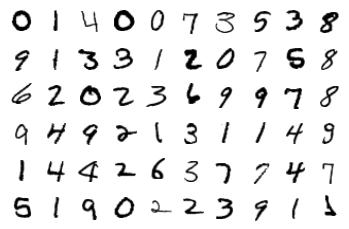

In [10]:
# visualize some images
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(np_features[index].reshape((28,28)), cmap='gray_r')
plt.show()

At this stage we have torch.Tensor object representing our data.

Now, we need to construct 
- torch.autograd.Variable objects - these will store our tensors and gradients
- torch.utils.data.DataLoader objects - these will provide the funcionality required to divide our images into batches

In [11]:
# Combine feature and target combinations into train and test sets 
train = torch.utils.data.TensorDataset(features_train,targets_train)
test = torch.utils.data.TensorDataset(features_test,targets_test)

This is also a useful stage to decide on hyperparameters, since one of them, `batch_size`, is required on DataLoader initialisation.

In [12]:
# some hyperparameters
batch_size = 100
n_iters = 10000
num_epochs = int(n_iters / (len(features_train) / batch_size))

In [13]:
# initialise DataLoader objects
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

__Now build a Logistic Regression model__

As we saw in Practical 9a, a model is defined as a Python class extending nn.Module

In [14]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_outputs):
        # initialise with Python super()
        super(LogisticRegressionModel, self).__init__()
        # linear regression activation
        self.linear = nn.Linear(n_features, n_outputs)
    
    def forward(self, x):
        return self.linear(x)



And that's it!!

But something is strange - the activation function is linear regression, not logistic regression...

The logistic part is taken care of y the loss function, which will use `nn.CrossEntropyLoss()` as its error:

In [15]:
# Cross Entropy Loss- note, this time we have 10 target outputs (classes) so we use CrossEntropyLoss() rather than BCELoss() (B is for Binary!)
error = nn.CrossEntropyLoss()

Instantiate the model

In [16]:
n_features = 784 # number of pixels per image
n_outputs = 10  # number of possible labes (0-9)

model = LogisticRegressionModel(n_features, n_outputs)
model

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

Use Stochastic Gradient Descent as in Practical9a.

In [17]:
# Another hyperparameter is learning rate
learning_rate = 0.001
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

Now, let's put our training loop in a function.

In [18]:
losses = []
iterations = []
def train_LogisticRegressionModel(model, num_epochs, train_loader, error, optimiser):
    count = 0
    global losses
    global iterations
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Define variables
            train = Variable(images.view(-1, 28*28))
            labels = Variable(labels)

            # Clear gradients
            optimiser.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculate gradients
            loss.backward()

            # Update parameters
            optimiser.step()

            count += 1
            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Predict test dataset
                for images, labels in test_loader: 
                    test = Variable(images.view(-1, 28*28))

                    # Forward propagation
                    outputs = model(test)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    # Total number of labels
                    total += len(labels)

                    # Total correct predictions
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                losses.append(loss.data)
                iterations.append(count)
                
                # Print Loss and accuracy
                print('Iteration: {}  Loss: {:.3f}  Accuracy: {:.3f}%'.format(count, loss.data, accuracy))

Run optimisation

In [19]:
%%time
losses = []
iterations = []
train_LogisticRegressionModel(model, num_epochs, train_loader, error, optimiser)

Iteration: 100  Loss: 2.165  Accuracy: 29.750%
Iteration: 200  Loss: 2.106  Accuracy: 44.429%
Iteration: 300  Loss: 1.990  Accuracy: 54.964%
Iteration: 400  Loss: 1.916  Accuracy: 61.369%
Iteration: 500  Loss: 1.809  Accuracy: 65.381%
Iteration: 600  Loss: 1.844  Accuracy: 68.083%
Iteration: 700  Loss: 1.734  Accuracy: 70.333%
Iteration: 800  Loss: 1.622  Accuracy: 72.381%
Iteration: 900  Loss: 1.600  Accuracy: 73.821%
Iteration: 1000  Loss: 1.604  Accuracy: 74.845%
Iteration: 1100  Loss: 1.427  Accuracy: 75.917%
Iteration: 1200  Loss: 1.383  Accuracy: 76.821%
Iteration: 1300  Loss: 1.488  Accuracy: 77.571%
Iteration: 1400  Loss: 1.407  Accuracy: 78.107%
Iteration: 1500  Loss: 1.284  Accuracy: 78.464%
Iteration: 1600  Loss: 1.263  Accuracy: 78.976%
Iteration: 1700  Loss: 1.237  Accuracy: 79.155%
Iteration: 1800  Loss: 1.260  Accuracy: 79.512%
Iteration: 1900  Loss: 1.169  Accuracy: 79.929%
Iteration: 2000  Loss: 1.194  Accuracy: 80.143%
Iteration: 2100  Loss: 1.145  Accuracy: 80.464%
I

Visualise the optimisation progress

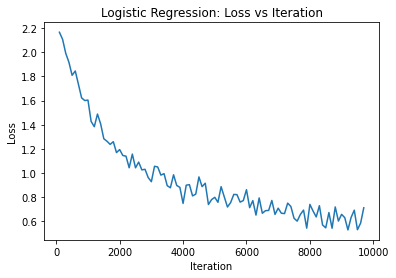

In [20]:
plt.plot(iterations,losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Iteration")
plt.show()

_Run the training a few times - notice what happens to the loss and accuracy values, and the plot._

Another useful visualisation is the probability that an image falls into a given class.
We'll do that for the test set.

In [21]:
def view_classify(img, probab):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probab = probab.squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probab)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.xlabel(f"Predicted Digit = {np.argmax(probab)}")

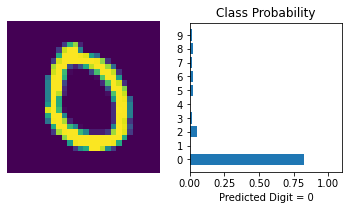

In [60]:
from random import randint
images, labels = next(iter(train_loader))

#select a random image
random_index = randint(0,len(images)-1)
img = images[random_index].view(1, 784)

#generate the inference for that image
#this gives the log probabilities
with torch.no_grad():
    logps = model(img)

#convert to probabilities
ps = torch.exp(logps).numpy()[0]
probab = ps / np.sum(ps)
view_classify(img.view(1, 28, 28), probab)

_Run the cell above multiple times to see some random images and their predicted classes._

Finally, save the model for future use - training is expensive, it's good practice to save the model so those resources are needed again!

In [61]:
torch.save(model, '9b_model.pt') 